In [1]:
import torch
import numpy as np

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('mpg')

In [3]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train)
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train)

initial loss:  910.264892578125
final loss:  2.337040901184082
initial loss:  848.6527099609375
final loss:  2.3558855056762695
initial loss:  732.0319213867188
final loss:  2.35137939453125
initial loss:  873.8779296875
final loss:  2.412376880645752
initial loss:  849.9519653320312
final loss:  2.3897318840026855
final loss:  2.5810015201568604


Deep ensemble test MAPE:  0.0815885


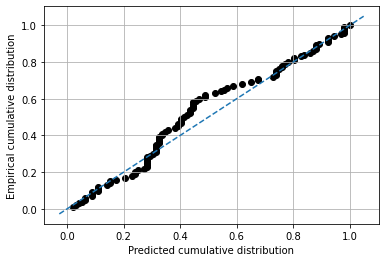

Deep ensemble test calibration error when step size is 0.001:  3.059937618147449
Deep ensemble test calibration error when step size is 0.01:  0.30549621928166365
Deep ensemble test calibration error when step size is 0.1:  0.03180529300567107


In [4]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

Concrete dropout test MAPE:  0.09006865


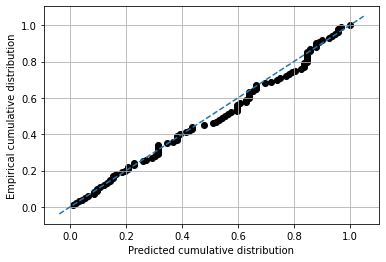

Concrete dropout test calibration error when step size is 0.001:  0.8579395085066159
Concrete dropout test calibration error when step size is 0.01:  0.08418714555765588
Concrete dropout test calibration error when step size is 0.1:  0.009191871455576546


In [5]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy())

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))